# COVID Global Clustering Scratchpad 

Do the same using Global data from John Hopkins University

https://github.com/CSSEGISandData/COVID-19   

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv


## Clustering thoughts
- Take case + death counts
- Trending pattern (?  what is a good single value metric.. rolling 3 day or some momentum value?)
- Adding population data
- Population density ?
- Median age and age distributions

Attempt to cluster the countries ?


In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import pandas as pd
import requests

dfc_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
dfd_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

dfc_g = dfc_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfc_graw.columns[-1], ascending=False).transpose()
dfc_g.index = pd.to_datetime(dfc_g.index)
display('cases',dfc_g.tail(3))

dfd_g = dfd_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfd_graw.columns[-1], ascending=False).transpose().tail(40)  # last 40 days ?
dfd_g.index = pd.to_datetime(dfd_g.index) 
display('deaths',dfd_g.tail(3))


'cases'

Country/Region,US,Spain,Italy,France,Germany,United Kingdom,Turkey,Iran,China,Russia,...,Gambia,Holy See,MS Zaandam,Papua New Guinea,Mauritania,Western Sahara,Bhutan,South Sudan,Sao Tome and Principe,Yemen
2020-04-20,784326,200210,181228,156480,147065,125856,90980,83505,83817,47121,...,10,9,9,7,7,6,5,4,4,1
2020-04-21,811865,204178,183957,159297,148291,130172,95591,84802,83853,52763,...,10,9,9,7,7,6,6,4,4,1
2020-04-22,840351,208389,187327,157125,150648,134638,98674,85996,83868,57999,...,10,9,9,8,7,6,6,4,4,1


'deaths'

Country/Region,US,Italy,Spain,France,United Kingdom,Belgium,Iran,Germany,China,Netherlands,...,Fiji,Chad,Bhutan,Central African Republic,Maldives,Seychelles,Mongolia,Eritrea,South Sudan,Sierra Leone
2020-04-20,42094,24114,20852,20292,16550,5828,5209,4862,4636,3764,...,0,0,0,0,0,0,0,0,0,0
2020-04-21,44444,24648,21282,20829,17378,5998,5297,5033,4636,3929,...,0,0,0,0,0,0,0,0,0,0
2020-04-22,46622,25085,21717,21373,18151,6262,5391,5279,4636,4068,...,0,0,0,0,0,0,0,0,0,0


## Add Trailing Avg Changes 3-day 7-day 14day

In [89]:
df_rolls = dfc_g.diff().rolling(3).mean().transpose().iloc[:,-1:]
df_rolls = df_rolls.rename(columns={df_rolls.columns[0]:'Cases3dayAvg'})
df_rolls['Cases7dayAvg'] = dfc_g.diff().rolling(7).mean().transpose().iloc[:,-1:]
df_rolls['Cases14dayAvg'] = dfc_g.diff().rolling(14).mean().transpose().iloc[:,-1:]
df_rolls['Deaths3dayAvg'] = dfd_g.diff().rolling(3).mean().transpose().iloc[:,-1:]
df_rolls['Deaths7dayAvg'] = dfd_g.diff().rolling(7).mean().transpose().iloc[:,-1:]
df_rolls['Deaths14dayAvg'] = dfd_g.diff().rolling(14).mean().transpose().iloc[:,-1:]
df_rolls = df_rolls.rename(index={'US':'United States'})
df_rolls.head()


,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg
Country/Region,,,,,,
United States,27180.666667,29143.000000,29406.928571,1987.000000,2612.000000,2279.857143
Spain,3238.333333,4392.142857,4297.785714,421.333333,429.857143,494.642857
Italy,2785.000000,3167.428571,3421.785714,475.000000,491.428571,529.714286
France,1009.333333,3220.428571,5290.571429,543.000000,597.857143,749.000000
Germany,1821.333333,2270.714286,2668.000000,231.000000,210.714286,209.285714


## Add Global Population by Country

In [90]:
# GLobal Population 
# https://github.com/datasets/population/blob/master/data/population.csv

df_gpop = pd.read_csv('https://raw.githubusercontent.com/datasets/population/master/data/population.csv')
df_gpop_2016 = df_gpop[df_gpop['Year'] == 2016]
df_gpop_2016.loc[df_gpop_2016['Country Code'] == 'RUS','Country Name'] = 'Russia'
df_gpop_2016.loc[df_gpop_2016['Country Code'] == 'IRN','Country Name'] = 'Iran'
df_gpop_2016.loc[df_gpop_2016['Country Code'] == 'COD','Country Name'] = 'Congo'
df_gpop_2016 = df_gpop_2016.rename(columns={'Country Name': 'Country/Region'})
display(df_gpop_2016[df_gpop_2016['Country/Region'].isin(['Italy','Russian Federation','Russia'])])

df_gmerged = pd.merge(left=dfc_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gpop_2016, on='Country/Region').rename(columns={'Value':'Population'})
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Cases" })

df_gmerged = pd.merge(left=dfd_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gmerged, on='Country/Region')
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Deaths" })

# merge rolling averages
df_gmerged = pd.merge(left=df_gmerged, right=df_rolls, on='Country/Region')

display(df_gmerged.sort_values(by=['Population'], ascending=False).head(10))  
display(dfc_g.iloc[0:1,:].count(axis=1), df_gmerged['Country/Region'].count())  # join check 185 in -> 159 out ?


C:\Users\dougc\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Country/Region,Country Code,Year,Value
8427,Italy,ITA,2016,60627498
12259,Russia,RUS,2016,144342396


,Country/Region,Deaths,Cases,Country Code,Year,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg
8,China,4636,83868,CHN,2016,1378665000,21.000000,73.142857,75.642857,0.000000,184.285714,92.785714
18,India,681,21370,IND,2016,1324509589,1251.666667,1292.571429,1103.857143,40.666667,39.428571,35.928571
0,United States,46622,840351,USA,2016,322941311,27180.666667,29143.000000,29406.928571,1987.000000,2612.000000,2279.857143
19,Indonesia,635,7418,IDN,2016,261554226,281.000000,326.000000,318.714286,17.666667,23.714286,28.214286
10,Brazil,2906,45757,BRA,2016,206163058,2367.666667,2491.000000,2113.357143,148.000000,167.142857,149.071429
32,Pakistan,212,10076,PAK,2016,203627284,576.000000,527.571429,415.214286,14.666667,14.428571,10.785714
71,Nigeria,28,873,NGA,2016,185960289,82.000000,66.571429,42.642857,2.333333,2.285714,1.571429
44,Bangladesh,120,3772,BGD,2016,157970840,438.666667,363.000000,253.857143,9.666667,10.000000,7.142857
23,Russia,513,57999,RUS,2016,144342396,5048.666667,4787.000000,3523.357143,50.666667,45.000000,32.142857
29,Japan,281,11512,JPN,2016,126994511,238.333333,487.428571,518.214286,15.000000,19.285714,13.428571


2020-01-22    185
dtype: int64

161

## Add Various Other Data from WorldBank.Org

In [91]:
# all available indicators https://data.worldbank.org/indicator
#    API docs https://datahelpdesk.worldbank.org/knowledgebase/articles/898581-api-basic-call-structures
#    I should bundle into a single request XLS or Json results, but alas.. this works for now
from zipfile import ZipFile
import requests, zipfile, io
import urllib.request

def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

def get_zip(url):
    urllib.request.urlretrieve(url, "X.zip")
    compressed_file = zipfile.ZipFile('X.zip')
    files = compressed_file.namelist()
    for f in files:
        if (f.find('API') == 0):
            csv_file = compressed_file.open(f)  # pattern match how?
            return pd.read_csv(csv_file, header=2)
    return None

def add_metric(indicator, colname, dfm, year='2019', debug=True):
    dfnew = get_zip('http://api.worldbank.org/v2/en/indicator/'+indicator+'?downloadformat=csv')
    dfnew = dfnew.fillna(method='ffill', axis=1)[['Country Code', year]].rename(columns={year:colname})

    dfm = pd.merge(left=dfm , right=dfnew, on ='Country Code') 
    display(dfm[dfm['Country/Region'].isin(['Dominica','Japan'])].head()) if debug else None

    dfm[colname] = dfm[colname].astype(str).apply(lambda x: float(x) if isfloat(x) else 0.0).round(2)
    return dfm


## Add demographics from worldbank

In [92]:
#   Examples:
# unemployment data http://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv
# hospital beds http://api.worldbank.org/v2/en/indicator/SH.MED.BEDS.ZS?downloadformat=csv
# air flights http://api.worldbank.org/v2/en/indicator/IS.AIR.DPRT?downloadformat=csv
# rail lines http://api.worldbank.org/v2/en/indicator/IS.RRS.TOTL.KM?downloadformat=csv
# employment F http://api.worldbank.org/v2/en/indicator/SL.TLF.CACT.FE.ZS?downloadformat=csv
# employment M http://api.worldbank.org/v2/en/indicator/SL.TLF.CACT.MA.ZS?downloadformat=csv
# unemployment http://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv
# urban pop% http://api.worldbank.org/v2/en/indicator/SP.URB.TOTL.IN.ZS?downloadformat=csv
# pollution EN.ATM.PM25.MC.M3
# slum% indicator/ EN.POP.SLUM.UR.ZS

df_gmerged3 = df_gmerged.copy()  # df_gmerged2 no longer needed

df_gmerged3 = add_metric('IS.AIR.DPRT', 'flights', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('EN.ATM.PM25.MC.M3', 'pollution', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SL.UEM.TOTL.ZS', 'unemp%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.MED.BEDS.ZS', 'hospbeds', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('IS.RRS.TOTL.KM', 'railways', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.URB.TOTL.IN.ZS', 'urbanpop%', df_gmerged3, year='2019', debug=False)
#df_gmerged3 = add_metric('EN.POP.SLUM.UR.ZS', 'slum%', df_gmerged3, year='2019', debug=False) # 0 data for g10's
df_gmerged3 = add_metric('EN.POP.DNST', 'popdensity%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('NY.GDP.PCAP.PP.CD', 'GDP/cap', df_gmerged3, year='2019', debug=False)
#df_gmerged3 = add_metric('SE.ADT.LITR.ZS', 'literacy', df_gmerged3, year='2019', debug=False) # 0 data for g10's
#df_gmerged3 = add_metric('FR.INR.DPST', 'deposit rate', df_gmerged3, year='2019', debug=False) # 0 data for g10's
df_gmerged3 = add_metric('IS.SHP.GOOD.TU', 'shipping', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.DYN.LE00.IN', 'lifeExpYrs', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('FP.CPI.TOTL.ZG', 'inflation', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.DYN.TFRT.IN', 'fertility', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.DTH.COMM.ZS', 'COD disease', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.IMM.IDPT', 'DTP immunized', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.POP.65UP.TO.ZS', 'pop% >= 65', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('TG.VAL.TOTL.GD.ZS', 'trade%', df_gmerged3, year='2019', debug=False)

df_gmerged3 = df_gmerged3.sort_values(by='Cases', ascending=False).drop(columns=['Year'])
df_gmerged3.head()

,Country/Region,Deaths,Cases,Country Code,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,...,popdensity%,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
0,United States,46622,840351,USA,322941311,27180.666667,29143.000000,29406.928571,1987.000000,2612.000000,...,35.77,62794.59,54688353.0,78.54,1.81,1.73,5.2,94.0,15.81,20.83
2,Spain,21717,208389,ESP,46484062,3238.333333,4392.142857,4297.785714,421.333333,429.857143,...,93.53,39715.44,17189759.0,83.33,0.70,1.31,5.1,93.0,19.38,51.67
1,Italy,25085,187327,ITA,60627498,2785.000000,3167.428571,3421.785714,475.000000,491.428571,...,205.45,41830.43,10547112.0,82.95,0.61,1.32,4.9,95.0,22.75,50.26
3,France,21373,157125,FRA,66721256,1009.333333,3220.428571,5290.571429,543.000000,597.857143,...,122.34,45342.40,6369200.0,82.53,1.11,1.90,6.0,96.0,20.03,45.16
7,Germany,5279,150648,DEU,82348669,1821.333333,2270.714286,2668.000000,231.000000,210.714286,...,237.37,53074.54,19597633.0,80.99,1.45,1.56,4.8,93.0,21.46,72.11


In [93]:
df_gmerged3.head(10).transpose()

,0,2,1,3,7,4,11,6,8,23
Country/Region,United States,Spain,Italy,France,Germany,United Kingdom,Turkey,Iran,China,Russia
Deaths,46622,21717,25085,21373,5279,18151,2376,5391,4636,513
Cases,840351,208389,187327,157125,150648,134638,98674,85996,83868,57999
Country Code,USA,ESP,ITA,FRA,DEU,GBR,TUR,IRN,CHN,RUS
Population,322941311,46484062,60627498,66721256,82348669,65611593,79821724,79564016,1378665000,144342396
Cases3dayAvg,27180.7,3238.33,2785,1009.33,1821.33,4488.67,4122.67,1261.67,21,5048.67
Cases7dayAvg,29143,4392.14,3167.43,3220.43,2270.71,5022.14,4183.14,1372.43,73.1429,4787
Cases14dayAvg,29406.9,4297.79,3421.79,5290.57,2668,5226,4317.71,1529.29,75.6429,3523.36
Deaths3dayAvg,1987,421.333,475,543,231,685.333,119.667,91,0,50.6667
Deaths7dayAvg,2612,429.857,491.429,597.857,210.714,751,122.571,87.7143,184.286,45


# Correlation Matrix

,Deaths,Cases,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg,flights,...,popdensity%,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
Deaths,1.000000,0.925235,0.178670,0.820235,0.854699,0.877213,0.949515,0.930311,0.956990,0.728200,...,-0.026648,0.249114,0.275349,0.176472,-0.040601,-0.165828,-0.161911,0.092695,0.301163,-0.081914
Cases,0.925235,1.000000,0.224432,0.957420,0.972778,0.980526,0.970926,0.977635,0.966799,0.878938,...,-0.024835,0.245843,0.319296,0.150907,-0.031126,-0.153106,-0.154511,0.087874,0.244198,-0.096038
Population,0.178670,0.224432,1.000000,0.187622,0.187153,0.179703,0.153759,0.197864,0.172705,0.505223,...,-0.018358,-0.041510,0.736949,0.023341,0.004186,-0.053001,-0.022162,0.033028,0.013806,-0.144005
Cases3dayAvg,0.820235,0.957420,0.187622,1.000000,0.996458,0.987024,0.933933,0.948887,0.919677,0.877450,...,-0.012726,0.223759,0.235866,0.116978,-0.022283,-0.132086,-0.130404,0.073761,0.178429,-0.089141
Cases7dayAvg,0.854699,0.972778,0.187153,0.996458,1.000000,0.996482,0.954686,0.966155,0.944107,0.877665,...,-0.017164,0.228142,0.238265,0.124373,-0.024402,-0.135646,-0.134767,0.075418,0.195706,-0.094794
Cases14dayAvg,0.877213,0.980526,0.179703,0.987024,0.996482,1.000000,0.968381,0.977732,0.961500,0.873326,...,-0.020477,0.231173,0.236569,0.129673,-0.025291,-0.135146,-0.137097,0.076974,0.206132,-0.095105
Deaths3dayAvg,0.949515,0.970926,0.153759,0.933933,0.954686,0.968381,1.000000,0.993563,0.996637,0.824774,...,-0.026078,0.249111,0.226325,0.153085,-0.035102,-0.146039,-0.145681,0.079154,0.260581,-0.085536
Deaths7dayAvg,0.930311,0.977635,0.197864,0.948887,0.966155,0.977732,0.993563,1.000000,0.993504,0.869881,...,-0.024372,0.231438,0.287705,0.137675,-0.032605,-0.133992,-0.135277,0.075147,0.233122,-0.087484
Deaths14dayAvg,0.956990,0.966799,0.172705,0.919677,0.944107,0.961500,0.996637,0.993504,1.000000,0.825824,...,-0.024794,0.241738,0.256543,0.149966,-0.035313,-0.142000,-0.142605,0.079831,0.255545,-0.082137
flights,0.728200,0.878938,0.505223,0.877450,0.877665,0.873326,0.824774,0.869881,0.825824,1.000000,...,-0.025708,0.223637,0.616125,0.137899,-0.034344,-0.157493,-0.149927,0.092093,0.185128,-0.103676


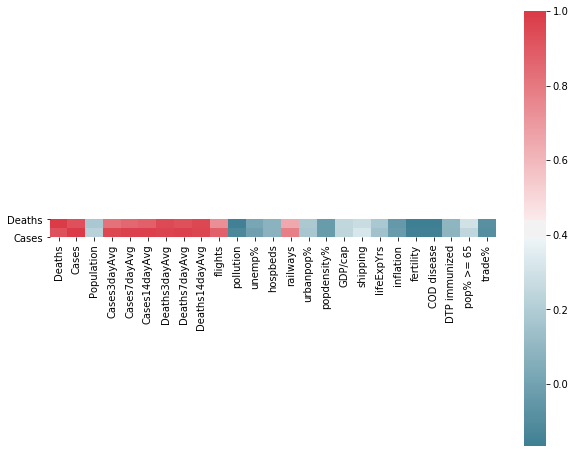

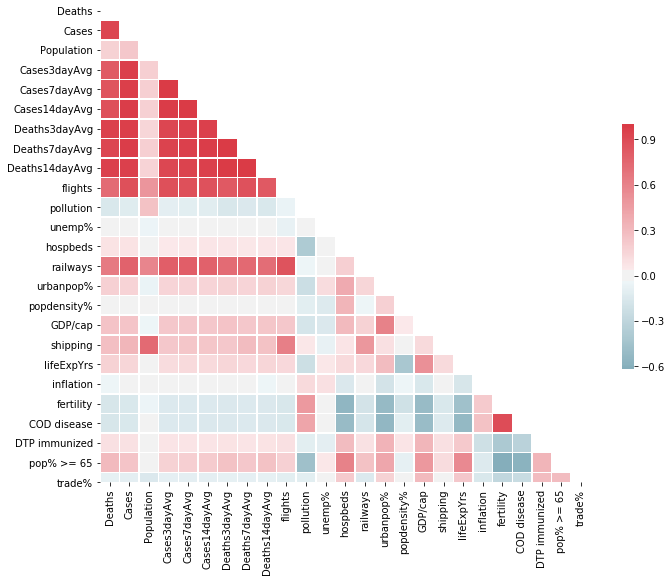

In [94]:
import seaborn as sns

df_corr = df_gmerged3.corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_corr.iloc[0:2,:], mask=np.zeros_like(df_corr.iloc[0:2,:], dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

df_corr


## Scaling / Normalization

In [95]:
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'
scaler = StandardScaler()

df_orig = df_gmerged3.copy().set_index('Country/Region').drop(columns=['Country Code'])
df_sc = pd.DataFrame(scaler.fit_transform(df_orig), index=df_orig.index, columns=df_orig.columns)

display('original',df_orig.head(2),'scaled',df_sc.head(2))

'original'

,Deaths,Cases,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg,flights,...,popdensity%,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,,,,
United States,46622,840351,322941311,27180.666667,29143.000000,29406.928571,1987.000000,2612.000000,2279.857143,9879630.0,...,35.77,62794.59,54688353.0,78.54,1.81,1.73,5.2,94.0,15.81,20.83
Spain,21717,208389,46484062,3238.333333,4392.142857,4297.785714,421.333333,429.857143,494.642857,641020.0,...,93.53,39715.44,17189759.0,83.33,0.70,1.31,5.1,93.0,19.38,51.67


'scaled'

,Deaths,Cases,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg,flights,...,popdensity%,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,,,,
United States,9.105261,11.359867,1.812369,11.889151,11.838544,11.794023,10.944075,11.427110,10.844698,10.921371,...,-0.182220,1.823748,2.675697,0.603148,-0.187901,-0.684111,-0.766188,0.399819,1.074270,-1.116918
Spain,4.120294,2.649731,0.021412,1.236534,1.608220,1.547690,2.156247,1.719946,2.194035,0.469807,...,-0.146901,0.803474,0.677905,1.034158,-0.260393,-1.009471,-0.770998,0.343845,1.616266,-0.258443


# Misc Clustering Techniques

## - Basic Template for KMeans

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

df_train = df_sc.copy()

kmeans = KMeans(n_clusters=3, random_state=0).fit(df_train) # train on sample rows

display(f'kmeans info - inertia: {kmeans.inertia_}, iters: {kmeans.n_iter_}')    # training info 
display(f'labels: {kmeans.labels_}')                       # k-labels

def fl_col(df, f=3, l=9):  # print first 3 and last 2 cols together
    return pd.concat([df.iloc[:,0:f],df.iloc[:,-l:]], axis=1)
    
df_train.insert(0, 'cluster', kmeans.labels_)
display('train', fl_col(pd.concat([df_train.head(5),
                            df_train[df_train.index.isin(['China','Japan','United States','Italy','Spain','India','Poland'])]])))
display(df_train[['cluster','Cases']].groupby(by=['cluster']).count())


'kmeans info - inertia: 2224.029938973404, iters: 8'

'labels: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0\n 2 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2\n 2 2 0 2 2 0 2 0 0 2 2 0 0 2 0 0 2 0 2 0 0 2 0 2 0 0 0 0 2 0 2 2 2 2 0 0 0\n 0 2 2 2 2 2 2 0 2 0 2 0 2 2 0 2 0 2 2 2 2 0 2 2 2 2 0 2 2 2 2 0 2 2 2 0 0\n 2 0 0 2 2 0 0 0 2 2 0 2 2]'

'train'

,cluster,Deaths,Cases,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,
United States,1,9.105261,11.359867,1.823748,2.675697,0.603148,-0.187901,-0.684111,-0.766188,0.399819,1.074270,-1.116918
Spain,0,4.120294,2.649731,0.803474,0.677905,1.034158,-0.260393,-1.009471,-0.770998,0.343845,1.616266,-0.258443
Italy,0,4.794431,2.359440,0.896973,0.324008,0.999965,-0.266271,-1.001724,-0.780618,0.455794,2.127899,-0.297692
France,0,4.051439,1.943175,1.052229,0.101424,0.962173,-0.233616,-0.552418,-0.727709,0.511769,1.714949,-0.439658
Germany,0,0.830076,1.853905,1.394048,0.806188,0.823602,-0.211412,-0.815805,-0.785428,0.343845,1.932051,0.310533
United States,1,9.105261,11.359867,1.823748,2.675697,0.603148,-0.187901,-0.684111,-0.766188,0.399819,1.074270,-1.116918
Spain,0,4.120294,2.649731,0.803474,0.677905,1.034158,-0.260393,-1.009471,-0.770998,0.343845,1.616266,-0.258443
Italy,0,4.794431,2.359440,0.896973,0.324008,0.999965,-0.266271,-1.001724,-0.780618,0.455794,2.127899,-0.297692
China,0,0.701373,0.933497,-0.146054,11.793459,0.437583,-0.116715,-0.715098,-0.833528,0.679693,0.331872,-0.751147


,Cases
cluster,
0,103
1,1
2,57


## - Basic Template for DBSCAN

I saw a presentation by Healy & McInnes on Youtube that basically said KMeans sucks, and we should use DBScan or their upgraded version HDBScan.   https://www.youtube.com/watch?v=ayZQj4llUSU&t=1824s


In [97]:
from sklearn.cluster import DBSCAN
import numpy as np

df_train = df_sc.copy()
clustering = DBSCAN(eps=3, min_samples=2).fit(df_train)
components = clustering.components_
labels =clustering.labels_
core_sample_indices = clustering.core_sample_indices_
display(f'model: {clustering}')

display(f'core_sample_indices_[0:10]: {core_sample_indices[0:10]}')
display(f'components_[0]: {components[0]}')    
display(f'labels/fit_predict[0:10]: {labels[0:10]}')                       

df_train.insert(0, 'cluster',clustering.labels_)
display('train2',pd.concat([fl_col(df_train).head(), 
                            fl_col(df_train[df_train.index.isin(['China','Japan','United States','Italy','Spain','India','Poland'])])]))
display(df_train[['cluster','Cases']].groupby(by=['cluster']).count().rename(columns={'Cases':'Count'}))


"model: DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',\n       metric_params=None, min_samples=2, n_jobs=None, p=None)"

'core_sample_indices_[0:10]: [ 1  2  3  5  6  7 10 11 13 14]'

'components_[0]: [ 4.12029404  2.64973116  0.02141183  1.23653436  1.60822016  1.54769038\n  2.1562467   1.71994558  2.19403547  0.46980672 -0.89882994  1.3720069\n  0.04930401  0.60599096  0.86717548 -0.14690117  0.80347416  0.67790503\n  1.03415791 -0.2603928  -1.00947095 -0.77099844  0.34384456  1.61626635\n -0.25844295]'

'labels/fit_predict[0:10]: [-1  0  0  0 -1  0  1  1 -1 -1]'

'train2'

,cluster,Deaths,Cases,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,
United States,-1,9.105261,11.359867,1.823748,2.675697,0.603148,-0.187901,-0.684111,-0.766188,0.399819,1.074270,-1.116918
Spain,0,4.120294,2.649731,0.803474,0.677905,1.034158,-0.260393,-1.009471,-0.770998,0.343845,1.616266,-0.258443
Italy,0,4.794431,2.359440,0.896973,0.324008,0.999965,-0.266271,-1.001724,-0.780618,0.455794,2.127899,-0.297692
France,0,4.051439,1.943175,1.052229,0.101424,0.962173,-0.233616,-0.552418,-0.727709,0.511769,1.714949,-0.439658
Germany,-1,0.830076,1.853905,1.394048,0.806188,0.823602,-0.211412,-0.815805,-0.785428,0.343845,1.932051,0.310533
United States,-1,9.105261,11.359867,1.823748,2.675697,0.603148,-0.187901,-0.684111,-0.766188,0.399819,1.074270,-1.116918
Spain,0,4.120294,2.649731,0.803474,0.677905,1.034158,-0.260393,-1.009471,-0.770998,0.343845,1.616266,-0.258443
Italy,0,4.794431,2.359440,0.896973,0.324008,0.999965,-0.266271,-1.001724,-0.780618,0.455794,2.127899,-0.297692
China,-1,0.701373,0.933497,-0.146054,11.793459,0.437583,-0.116715,-0.715098,-0.833528,0.679693,0.331872,-0.751147


,Count
cluster,
-1,13
0,4
1,142
2,2


---

# Dimension Reduction

## - PCA Method

Most research tells us due to "Curse of Dimensionality" that you need to reduce dims before you run clustering.  Hence we redo.

[Text(0, 0.5, 'PCA3')]

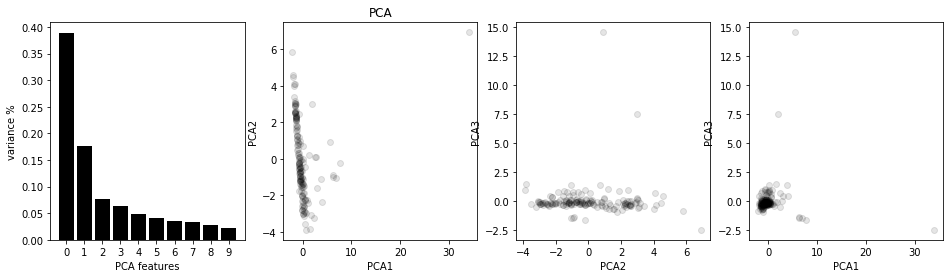

In [98]:
# method copied from kaggle: https://www.kaggle.com/minc33/visualizing-high-dimensional-clusters
#sklearn imports
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'

plotX = df_sc.copy()

pca = PCA(n_components=10)
principalComponents = pca.fit_transform(plotX)
PCA_components = pd.DataFrame(principalComponents, index=plotX.index)

# Plot the explained variances
features = range(pca.n_components_)

fig,ax = plt.subplots(1,4, figsize=(16,4))

ax[0].bar(features, pca.explained_variance_ratio_, color='black')
ax[0].set(xlabel = 'PCA features')
ax[0].set(ylabel = 'variance %')
ax[0].set(xticks = features)

ax[1].scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
ax[1].set(xlabel = 'PCA1')
ax[1].set(ylabel = 'PCA2')
ax[1].set(title='PCA')

ax[2].scatter(PCA_components[1], PCA_components[2], alpha=.1, color='black')
ax[2].set(xlabel = 'PCA2')
ax[2].set(ylabel = 'PCA3')

ax[3].scatter(PCA_components[0], PCA_components[2], alpha=.1, color='black')
ax[3].set(xlabel = 'PCA1')
ax[3].set(ylabel = 'PCA3')



## 

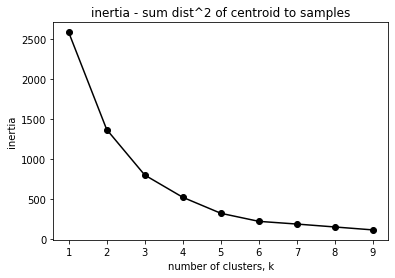

In [99]:
# KMeans on PCA columns - the elbow check !
def elbow_check(df_km):
    ks = range(1, 10)
    inertias = []
    for k in ks:
        model = KMeans(n_clusters=k)
        model.fit(df_km.iloc[:,:3])
        inertias.append(model.inertia_)

    plt.plot(ks, inertias, '-o', color='black')
    plt.title('inertia - sum dist^2 of centroid to samples')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()
    
elbow_check(PCA_components)

## KMeans Cluster Variants and Plots

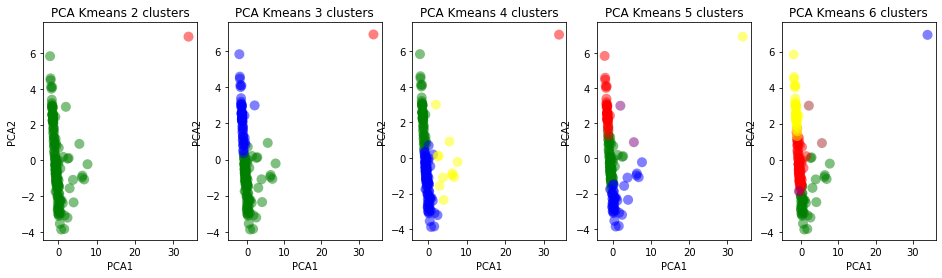

In [100]:
cluster_cases = [2,3,4,5,6]

def plot_clusters(cluster_name, cluster_cases, df_comp, dims=2):
    fig,ax = plt.subplots(1,len(cluster_cases), figsize=(16,4))

    for c,clusters in enumerate(cluster_cases):
        model = KMeans(n_clusters=clusters)
        df_comp2 = df_comp.copy()
#        m = model.fit(df_comp2.iloc[:,:dims])
        m = model.fit(df_comp2)
        df_comp2.insert(0, 'cluster', m.labels_)

        datas = []
        for i in range(clusters): 
            tup = []
            for j in range(dims):  ## should be cluster dims? pca dims?
                tup.append(df_comp2[df_comp2['cluster']==i][j])
            datas.append(tup)

        groups = [cluster_name+str(i) for i in range(clusters)]
        colors = ('green','red','blue','yellow','purple','brown')

        for data,color,group in zip(datas,colors,groups):
            x,y = data[0],data[1]
            ax[c].scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=100, label=group)
            ax[c].set_title(f'{cluster_name} Kmeans {clusters} clusters')
            ax[c].set(xlabel=cluster_name+'1')
            ax[c].set(ylabel=cluster_name+'2')
    plt.show()

# hmm which one to pick?
plot_clusters('PCA', cluster_cases, PCA_components)



## KMeans with Point Labels

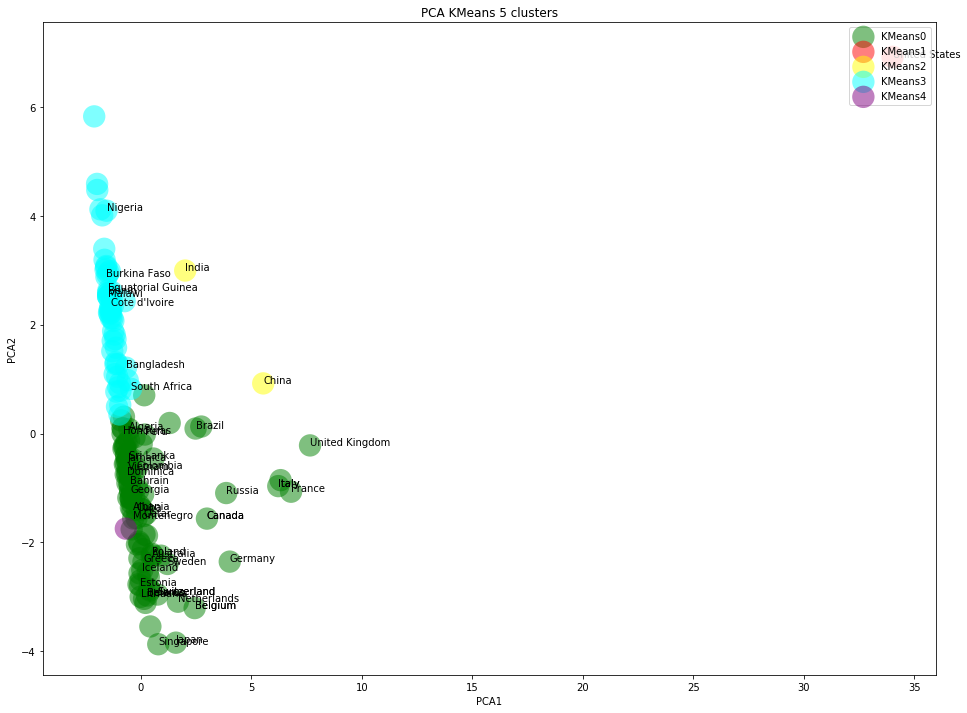

In [127]:
def plot_big(clustering_name, reducer_name, model, df_comp, dims=2, countries=30):
    df_comp2 = df_comp.copy()
    fig,ax = plt.subplots(figsize=(16,12))

    m = model.fit(df_comp2)  # first 3 cols, or dims
    df_comp2.insert(0, 'cluster', m.labels_)
    
    datas = []
    for i in range(len(set(m.labels_))):
        tup = []
        for j in range(dims):
            tup.append(df_comp2[df_comp2['cluster']==i][j])
        datas.append(tup)

    groups = [clustering_name+str(i) for i in range(len(set(m.labels_)))]
    colors = ('green','red','yellow','cyan','purple','brown')

    for data,color,group in zip(datas,colors,groups):
        x,y = data[0],data[1]
        ax.scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=500, label=group)
        ax.set_title(f'{reducer_name} {clustering_name} {len(set(m.labels_))} clusters')
        ax.set(xlabel=f'{reducer_name}1')
        ax.set(ylabel=f'{reducer_name}2')

    for index,row in df_comp2[df_comp2.index.isin(['United Kingdom','Belgium','Canada', 'France', 'Germany', 'Italy', 'Netherlands', 'Sweden', 'Switzerland','Canada','Japan','United States','China','Australia','Singapore','South Africa','Belarus','Brazil','Russia','India','Poland'])].iterrows():
        ax.annotate(index, (row[0],row[1]))
    for index,row in df_comp2.sample(countries).iterrows():
        ax.annotate(index, (row[0],row[1]))

    plt.legend(loc=1)
    plt.show()
    
# zoom on n cluster solution
clusters=5
model = KMeans(n_clusters=clusters)
plot_big('KMeans','PCA',model, PCA_components)


## -T-SNE Method (T-Distributed Stochastic Neighbor Embedding)

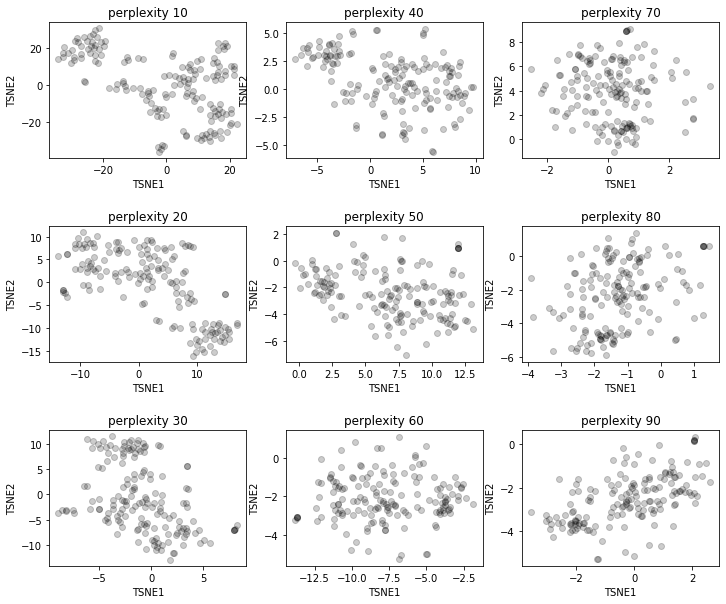

In [102]:
plotX = df_train.copy()
ps = [10,20,30,40,50,60,70,80,90]

fig,ax = plt.subplots(3, 3, figsize=(12,10))
plt.subplots_adjust(hspace=.5)
import math 

# the search for ideal perplexity hyperameters...
for i, perplexity in enumerate(ps):
    tsne = TSNE(n_components=2, perplexity=perplexity)
    tsneComponents = tsne.fit_transform(plotX.drop(["cluster"], axis=1))
    TSNE_components = pd.DataFrame(tsneComponents, index=plotX.index)

    ax[i%3][math.floor(i/3)].set_title(f'perplexity {perplexity}')
    ax[i%3][math.floor(i/3)].scatter(TSNE_components[0], TSNE_components[1], alpha=.2, color='black')
    ax[i%3][math.floor(i/3)].set(xlabel = 'TSNE1')
    ax[i%3][math.floor(i/3)].set(ylabel = 'TSNE2')


## Fixing TSNE HyperParams (Perplexity and Comps)

In [103]:
# pick perp 30 randomly, comps 2 or 3 (plot dimensions I think)
tsne = TSNE(n_components=2, perplexity=30)
tsneComponents = tsne.fit_transform(plotX.drop(["cluster"], axis=1))
TSNE_components = pd.DataFrame(tsneComponents, index=plotX.index)
TSNE_components.head()

,0,1
Country/Region,,
United States,-6.853132,12.181935
Spain,-7.726995,11.771605
Italy,-7.731576,11.773942
France,-7.685504,11.787235
Germany,-9.634266,8.926648


## KMeans w/ TSNE

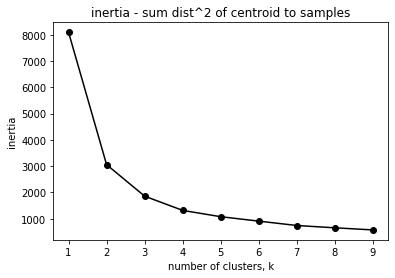

In [104]:
# KMeans on TSNE columns, search or the elbow ?

elbow_check(TSNE_components)

## KMeans on TSNE Cluster Analysis

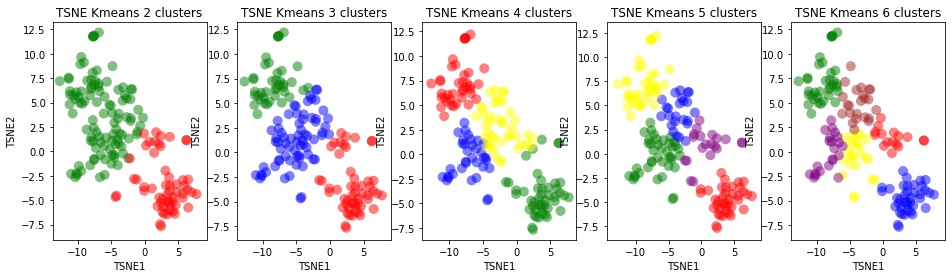

In [105]:
cluster_cases = [2,3,4,5,6]
plot_clusters('TSNE', cluster_cases, TSNE_components)

# hmm which one to pick?

## KMeans on TSNE - Zoom with Labels

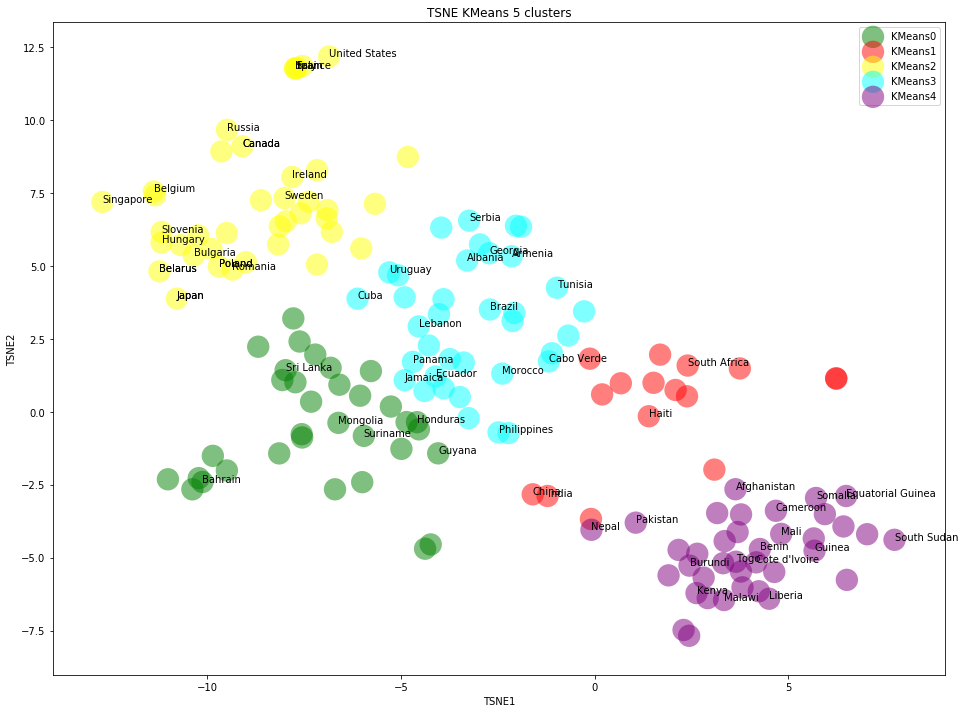

In [106]:
# try 6 clusters -- why i dunno, looks good... 
model = KMeans(n_clusters=5)            
plot_big('KMeans','TSNE',model, TSNE_components, countries=50)

---
## DBScan on PCA Cluster Analysis


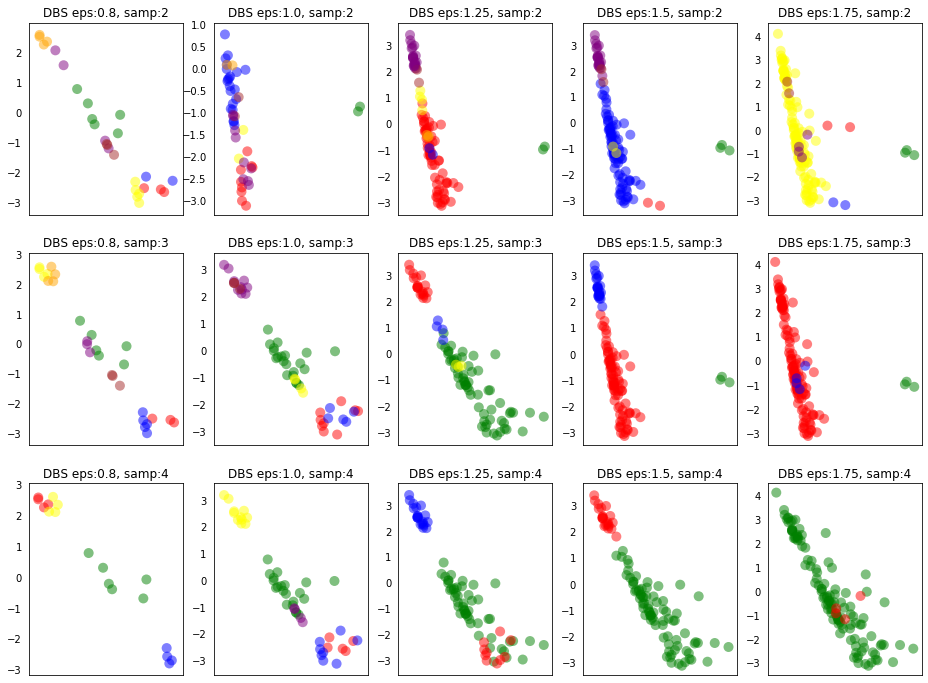

In [107]:
from sklearn.cluster import DBSCAN
import numpy as np
from itertools import product

# try a variety of eps & samples 
samp_list = [2,3,4]
eps_list = [0.8, 1.0, 1.25, 1.5, 1.75]
rl = len(samp_list)

fig, ax = plt.subplots(len(samp_list), len(eps_list), figsize=(16,12))

for k, (eps, samp) in enumerate(product(eps_list, samp_list)):
    PCA_components3 = PCA_components.copy()

    ax[k%rl][math.floor(k/rl)].tick_params(axis='both',which='both',bottom=False,top=False,left=False,labelbottom=False) 
    clustering = DBSCAN(eps=eps, min_samples=samp).fit(PCA_components3)
    PCA_components3.insert(0, 'cluster', clustering.labels_)

    datas = []
    for i in range(len(set(clustering.labels_))): 
#         tup = []
#         for j in range(2):  # 2d hardcoded
#             tup.append(PCA_components3[PCA_components3['cluster']==i][j])
        tup = [PCA_components3[PCA_components3['cluster']==i][j] for j in range(2)]
        datas.append(tup)

    colors = ('green','red','blue','yellow','purple','brown','orange','purple')
    groups = [str(i) for i in range(len(set(clustering.labels_)))]

    for data,color,group in zip(datas,colors,groups):
        x,y = data[0],data[1]
        ax[k%rl][math.floor(k/rl)].scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=100, label=group)
        ax[k%rl][math.floor(k/rl)].set_title(f'DBS eps:{eps}, samp:{samp}')


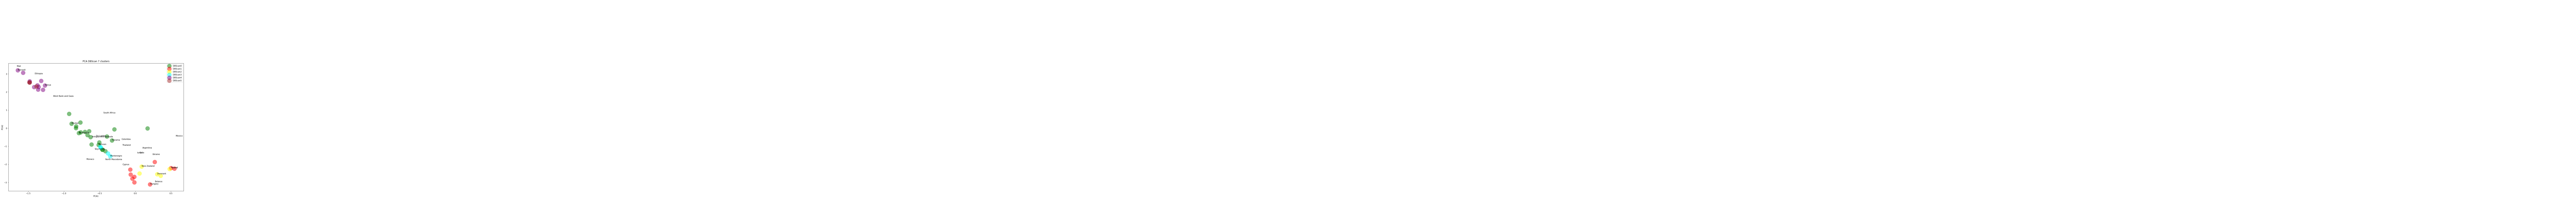

In [108]:
PCA_components3 = PCA_components.copy()
clustering = DBSCAN(eps=1, min_samples=3).fit(PCA_components3)
plot_big('DBScan','PCA',clustering, PCA_components3) # bug w/ DBAcan use ..'


## DBScan on TSNE Cluster Analysis

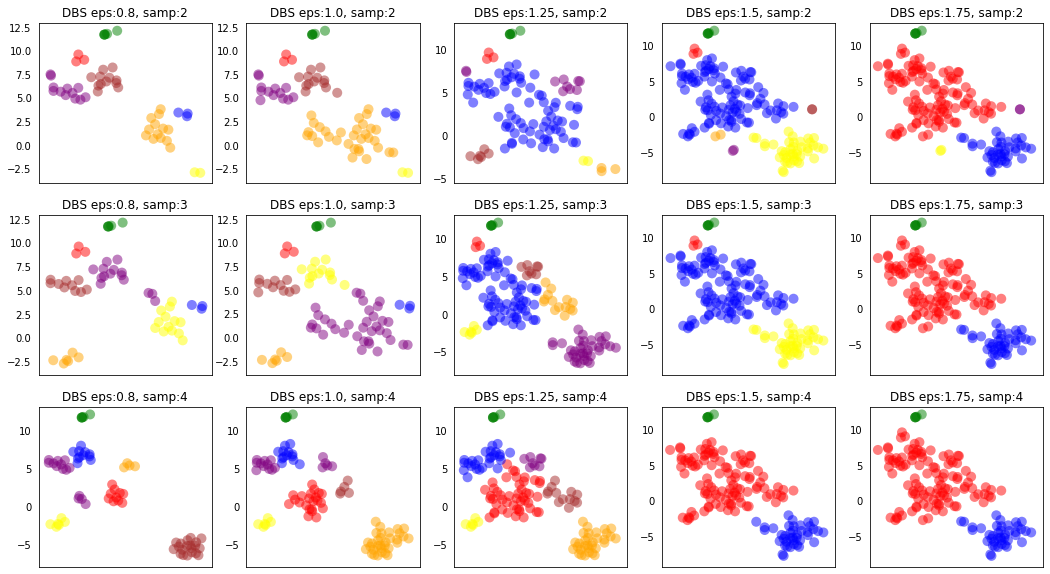

In [116]:
from sklearn.cluster import DBSCAN
import numpy as np
from itertools import product
from math import floor  

samp_list = [2,3,4]
eps_list = [0.8, 1.0, 1.25, 1.5, 1.75]
rows = len(samp_list)

fig, ax = plt.subplots(len(samp_list), len(eps_list), figsize=(18,10))

for k, (eps, samp) in enumerate(product(eps_list, samp_list)):
    ax[k%rows][floor(k/rows)].tick_params(axis='both',which='both',bottom=False,top=False,left=False,labelbottom=False) 

    TSNE_df = TSNE_components.copy()
    clustering = DBSCAN(eps=eps, min_samples=samp).fit(TSNE_df)
    TSNE_df.insert(0, 'cluster', clustering.labels_)

    datas = [[TSNE_df[TSNE_df['cluster']==i][j] for j in range(2)] for i in range(len(set(clustering.labels_)))]
    colors = ('green','red','blue','yellow','purple','brown','orange','purple')
    groups = [str(i) for i in range(len(set(clustering.labels_)))]

    for data,color,group in zip(datas,colors,groups):
        ax[k%rows][floor(k/rows)].scatter(data[0],data[1], alpha=0.5, c=color, edgecolors='none', s=100, label=group)
        ax[k%rows][floor(k/rows)].set_title(f'DBS eps:{eps}, samp:{samp}')


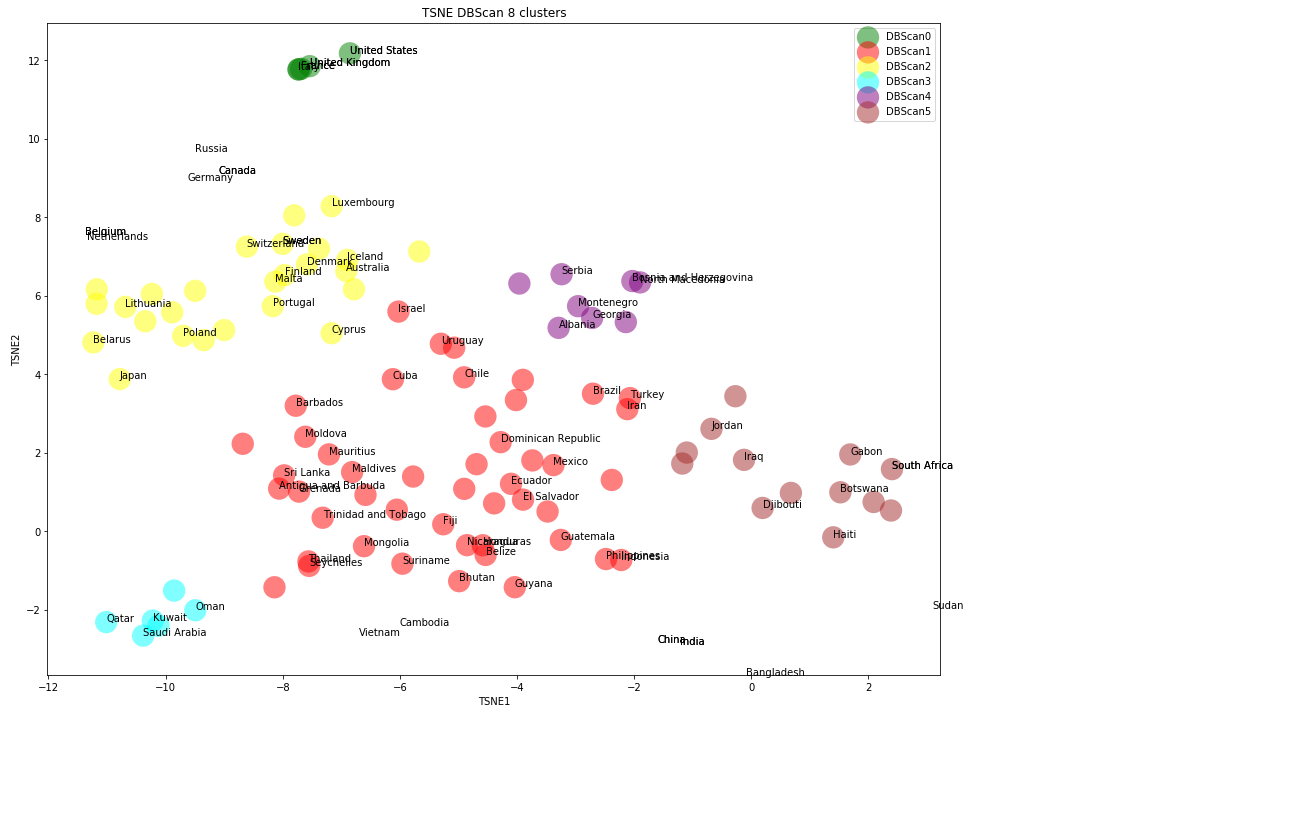

In [128]:
TSNE_df = TSNE_components.copy()
clustering = DBSCAN(eps=1.25, min_samples=4).fit(TSNE_df)
plot_big('DBScan','TSNE',clustering, TSNE_df, countries=100)

In [ ]:
df_gmerged3.head()

In [ ]:
dfc_g['Russia']
df_gmerged3[df_gmerged3['Country/Region'] == 'Russia']

In [ ]:
import plotly.graph_objects as go
import pandas as pd

df = df_gmerged3.copy()

fig = go.Figure(data=go.Choropleth(
    locations = df['Country Code'],
    z = df['Cases'].apply(np.log),
    text = df['Country/Region'],
    colorscale = 'Reds',
#    colorscale = ['rgb(245,245,245)', 'rgb(254,224,210)', 'rgb(252,187,161)', 'rgb(252,146,114)', 'rgb(251,106,74)', 'rgb(239,59,44)', 'rgb(203,24,29)', 'rgb(165,15,21)', 'rgb(103,0,13)'],
    autocolorscale=False,
    colorbar=dict(
            title="Cases",
            titleside="top",
            tickmode="array",
            tickvals=[2, 4 ,7, 9, 11, 13],
            ticktext=["10", "100", "500", "1k",  "50k", "300k+"],
            ticks="outside"
        )))

fig.update_layout(
    title_text='Global COVID Cases',
    geo=dict(showframe=False, showcoastlines=False, projection_type='equirectangular' ),
    annotations = [dict(
        x=0.55, y=0.1,
        xref='paper', yref='paper',
        text='Source: <a href="https://github.com/dougfoo/machineLearning/covid"> John Hopkins + WorldBank</a>',
        showarrow = False
    )]
)

fig.show()
